In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import random
from sklearn.metrics import mean_squared_error,mean_absolute_error,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler,PowerTransformer,StandardScaler
from sklearn.model_selection import KFold
import pickle
pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 1000)  # or 1000
import time
from numpy import concatenate
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [68]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
print(cd)
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short: ')
winter = input('Winter data or not? (Y/N)')
if winter =='Y':
    all_df = pd.read_csv(lakename+'_Observation_df.csv',sep = '\t',parse_dates = ['Date'])
else:
    all_df = pd.read_csv(lakename+'_Observation_df_nowinter5.csv',sep = '\t',parse_dates = ['Date'])
    
all_df=all_df.drop_duplicates(subset=['Date'])

C:\Users\shuli278\Documents\D\PDF_Uppsala\7-Python code of ML algorithm\GitHub\Algal-bloom-prediction-machine-learning\Algal-bloom-prediction-machine-learning\Scenario2\LSTM
Load training data (containing nutrient observations)
Lake name in short: Fureso
Winter data or not? (Y/N)Y


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

# Load testing dataset(Daily data)
def read_daily_df(features,file):
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    return Lake_HydMet

# reframe dataset
def reframe(values,hyperparameters,var_names):
    reframed = series_to_supervised(values, hyperparameters['time_steps'], hyperparameters['n_out'],var_names)
    reframed = reframed.iloc[hyperparameters['time_steps']:]
    drop_col =[]
    n_var = len(var_names)
    for i in range(1,hyperparameters['time_steps']+1):
        drop_col += [n_var*i-1]
    reframed.drop(reframed.iloc[:,drop_col],axis=1,inplace = True)
    return reframed

# load dataset
def load_dataset(df,var_name):
    values = df[var_name].values
    return values

def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose,loss_function):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss=loss_function, optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

def split_dataset(train,test,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    test_X = test_X.reshape((test_X.shape[0], time_steps+1, int(test_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y,test_X, test_y

def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,mae,r2,nutrient,test_time,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(concatenate((yhat.reshape(yhat.shape[0],1),y.reshape(y.shape[0],1)), axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])
    # Compute the 7d rolling mean of the timeseries predction
    pred_ts['Prediction_7d'] = pred_ts['Prediction'].rolling(7,min_periods = 1).mean()
    # Create a continous timeseries without winter gap
    Date = pd.DataFrame(pd.date_range(start = time_ts.iloc[0],
                                  end = time_ts.iloc[-1]),
                    columns = ['Date'])
    pred_ts_gap = Date.merge(pred_ts,how = 'left',on = 'Date')
    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts_gap.plot(x = 'Date',y = ['Prediction','Prediction_7d'],
                     style = {'Prediction':'b-','Prediction_7d':'k-'},
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((test_time[0],test_time[1]))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}, MAE:{}'.format(round(rmse,2),round(mae,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    ax1[0].legend(frameon=False)
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1,pred_ts

# ensure all data is float
def predict_lstm(df,values,var_name,nutrient,test_time,hyperparameters,ylim):
    n_date = df[(df['Date']<test_time[0])|(df['Date']>test_time[1])]['Date'].count() # number of dates used for trainning
    if df[(df['Date']<test_time[0])].empty:
        train = values[-n_date-1:-1, :] # Testing years are in front of training years: train = values[-n_date-1:-1, :]
        test = values[:-n_date, :] # Testing years are in front of training years: test = values[:-n_date, :]
    if df[(df['Date']>test_time[1])].empty:
        train = values[:n_date, :] # Testing years are after training years: train = values[:n_date, :]
        test = values[n_date:, :] # Testing years are after training years: test = values[n_date:, :]
    train_X, train_y,test_X, test_y = split_dataset(train,test,hyperparameters['time_steps'])
    train_y=Scaler_y.fit_transform(train_y.reshape(-1, 1))
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    #y_scaled = Scaler.fit_transform(y.reshape(-1,1))
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    MAE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = fit_lstm(X_train,y_train,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                         hyperparameters['n_neuros'],hyperparameters['dropout'],
                         hyperparameters['verbose'],hyperparameters['loss_function'])
        yhat = Scaler_y.inverse_transform(model.predict(X_test,batch_size = hyperparameters['n_batch']))
        y_test = Scaler_y.inverse_transform(y_test.reshape(-1, 1))
        rmse = mean_squared_error(y_test, yhat,squared=False)
        mae= mean_absolute_error(y_test, yhat)
        r2 =  r2_score(y_test, yhat)
        RMSE.append(rmse) 
        MAE.append(mae)
        R2.append(r2)
        #print('Training RMSE: %.2f' %rmse)       
    # make a prediction
    model = fit_lstm(X,y,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                     hyperparameters['n_neuros'],hyperparameters['dropout'],
                     hyperparameters['verbose'],hyperparameters['loss_function'])
    index,X,y = sparse_dataset(test_X,test_y)#sparse_dataset(test_X,Scaler_y.inverse_transform(test_y.reshape(-1, 1))) # index is the time series
    yhat = Scaler_y.inverse_transform(model.predict(X,batch_size = hyperparameters['n_batch']))
    rmse = mean_squared_error(y, yhat,squared=False)
    mae = mean_absolute_error(y,yhat)
    r2 = r2_score(y, yhat)
    print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
    print("Training dataset MAE %.2f (+/- %.2f)" % (np.mean(MAE), np.std(MAE)))
    print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
    # make a prediction for the whole timeseries
    yhat_ts = Scaler_y.inverse_transform(model.predict(test_X,batch_size = hyperparameters['n_batch']))
    figure,pred_ts = plot_comparison(df,y,yhat,yhat_ts,n_date,hyperparameters['time_steps'],index,rmse,mae,r2,nutrient,test_time,ylim)
    return model,rmse,mae,r2,figure,pred_ts

def compare(Erken_Nut,Nut_memory,nutrient,Lake_Nut_metrics,hat):
    compare = Erken_Nut.merge(Nut_memory,on = 'Date',how = 'left')[['Date',nutrient+'_x',nutrient+'_y']].dropna()
    compare.columns = [['Date','ML','OB']]
    Lake_Nut_metrics[nutrient].MAE= mean_absolute_error(compare['OB'], compare['ML'])
    Lake_Nut_metrics[nutrient].RMSE = mean_squared_error(compare['OB'], compare['ML'],squared=False)
    Lake_Nut_metrics[nutrient].R2 = r2_score(compare['OB'], compare['ML'])
    # Add the time-series prediction into sample dataset for next variable modeling
    Nut_memory.loc[Nut_memory['year'].isin(test_yr),nutrient] = hat
    return Lake_Nut_metrics,Nut_memory

def predict_ts(df,nutrient,model,hyperparameters,values):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], hyperparameters['time_steps']+1, int(value_X.shape[1]/(hyperparameters['time_steps']+1))))
    y_pred = Scaler_y.inverse_transform(model.predict(value_X,batch_size = hyperparameters['n_batch']))    
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df

# Load testing dataset(Daily data)
def read_daily_df(features,file):
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    return Lake_HydMet

In [4]:
# Define the features and years
## Specify the training year
year = all_df['Date'].apply(lambda d:d.year).unique()
print('Dataset contains years:{},in total {} years'.format(year,len(year)))#[2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016] 
num_trainingyr = int(input('Number of years for training:'))
training_yr = []
for i in range(num_trainingyr):
    yr = int(input('Training year:'))
    training_yr.append(yr)

Dataset contains years:[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2017 2019
 2016 2018],in total 30 years
Number of years for training:20
Training year:1990
Training year:1991
Training year:1992
Training year:1993
Training year:1994
Training year:1995
Training year:1996
Training year:1997
Training year:1998
Training year:1999
Training year:2000
Training year:2001
Training year:2002
Training year:2003
Training year:2004
Training year:2005
Training year:2006
Training year:2007
Training year:2008
Training year:2009


In [8]:
## Dataset_range
Dataset_range = [pd.Timestamp(int(input('Dataset starts in year:')),1,1),
             pd.Timestamp(int(input('Dataset ends in year:')),12,31)]

Dataset starts in year:1990
Dataset ends in year:2018


In [69]:
print(all_df.info())
n_feature = int(input('Number of daily features used for training: '))

features = ['Date']
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10609 entries, 0 to 10608
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10609 non-null  datetime64[ns]
 1   Chl        483 non-null    float64       
 2   NOX        500 non-null    float64       
 3   DO_sur     495 non-null    float64       
 4   DO_bot     450 non-null    float64       
 5   PO4        499 non-null    float64       
 6   NH4        518 non-null    float64       
 7   TotP       499 non-null    float64       
 8   TotN       500 non-null    float64       
 9   inflow     10590 non-null  float64       
 10  thermD     10590 non-null  float64       
 11  delT       10590 non-null  float64       
 12  U          10590 non-null  float64       
 13  AirP       10590 non-null  float64       
 14  AirT       10590 non-null  float64       
 15  Hum        10590 non-null  float64       
 16  CC         10590 non-null  float64      

In [7]:
test_time = [pd.Timestamp(int(input('test starts in year:')),1,1),
             pd.Timestamp(int(input('test ends in year:')),12,31)]
test_yr=list(range(test_time[0].year,test_time[1].year+1))

test starts in year:2010
test ends in year:2018


In [70]:
# Create the daily df with Nan in nutrients columns'
print(all_df.info())
n_Nut = int(input('Number of nutrients: (including Chl and put them in order)'))
Nut_f = ['Date']
for i in range(n_Nut):
    f = input('Nutrients: ')
    Nut_f.append(f)
print(Nut_f)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10609 entries, 0 to 10608
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10609 non-null  datetime64[ns]
 1   Chl        483 non-null    float64       
 2   NOX        500 non-null    float64       
 3   DO_sur     495 non-null    float64       
 4   DO_bot     450 non-null    float64       
 5   PO4        499 non-null    float64       
 6   NH4        518 non-null    float64       
 7   TotP       499 non-null    float64       
 8   TotN       500 non-null    float64       
 9   inflow     10590 non-null  float64       
 10  thermD     10590 non-null  float64       
 11  delT       10590 non-null  float64       
 12  U          10590 non-null  float64       
 13  AirP       10590 non-null  float64       
 14  AirT       10590 non-null  float64       
 15  Hum        10590 non-null  float64       
 16  CC         10590 non-null  float64      

In [71]:
Lake_Nut_metrics = pd.DataFrame(columns = Nut_f[1:],index=['MAE','RMSE','R2'])
Nut_df=all_df[Nut_f]

In [72]:
# set the hyperparameters
hyperparameters = {'n_batch':20,'nb_epoch':100,'n_neuros':100,'dropout':0.2,'time_steps':7,
                   'n_out':1,'verbose':0,'loss_function':'mae'}

In [45]:
features.insert(0,'Date')

In [54]:
features.pop()

'W'

NOX
(7304, 8, 11) (7304,) (3279, 8, 11) (3279,)
number of input timesteps: 8
number of features: 11
number of samples: 368
Training dataset RMSE 0.13 (+/- 0.02)
Training dataset MAE 0.09 (+/- 0.01)
Training dataset R2 0.49 (+/- 0.16)
Test RMSE: 0.07
Test MAE: 0.04
Test R2: 0.68
Model takes 9 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


DO_sur
(7304, 8, 12) (7304,) (3279, 8, 12) (3279,)
number of input timesteps: 8
number of features: 12
number of samples: 363
Training dataset RMSE 1.73 (+/- 0.19)
Training dataset MAE 1.28 (+/- 0.12)
Training dataset R2 0.44 (+/- 0.02)
Test RMSE: 1.28
Test MAE: 0.91
Test R2: 0.66
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


DO_bot
(7304, 8, 13) (7304,) (3279, 8, 13) (3279,)
number of input timesteps: 8
number of features: 13
number of samples: 332
Training dataset RMSE 2.25 (+/- 0.14)
Training dataset MAE 1.75 (+/- 0.12)
Training dataset R2 0.74 (+/- 0.03)
Test RMSE: 1.99
Test MAE: 1.44
Test R2: 0.63
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


PO4
(7304, 8, 14) (7304,) (3279, 8, 14) (3279,)
number of input timesteps: 8
number of features: 14
number of samples: 367
Training dataset RMSE 0.10 (+/- 0.01)
Training dataset MAE 0.07 (+/- 0.00)
Training dataset R2 0.19 (+/- 0.05)
Test RMSE: 0.03
Test MAE: 0.02
Test R2: 0.46
Model takes 8 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


TotP
(7304, 8, 15) (7304,) (3279, 8, 15) (3279,)
number of input timesteps: 8
number of features: 15
number of samples: 367
Training dataset RMSE 0.07 (+/- 0.01)
Training dataset MAE 0.05 (+/- 0.01)
Training dataset R2 0.25 (+/- 0.16)
Test RMSE: 0.02
Test MAE: 0.02
Test R2: 0.44
Model takes 5 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


TotN
(7304, 8, 16) (7304,) (3279, 8, 16) (3279,)
number of input timesteps: 8
number of features: 16
number of samples: 368
Training dataset RMSE 0.21 (+/- 0.01)
Training dataset MAE 0.15 (+/- 0.01)
Training dataset R2 0.08 (+/- 0.11)
Test RMSE: 0.15
Test MAE: 0.12
Test R2: -0.22
Model takes 5 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


NH4
(7304, 8, 17) (7304,) (3279, 8, 17) (3279,)
number of input timesteps: 8
number of features: 17
number of samples: 367
Training dataset RMSE 0.05 (+/- 0.02)
Training dataset MAE 0.02 (+/- 0.01)
Training dataset R2 -0.04 (+/- 0.22)
Test RMSE: 0.02
Test MAE: 0.01
Test R2: -0.45
Model takes 5 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chl
(7304, 8, 18) (7304,) (3279, 8, 18) (3279,)
number of input timesteps: 8
number of features: 18
number of samples: 351
Training dataset RMSE 23.19 (+/- 4.87)
Training dataset MAE 12.80 (+/- 2.33)
Training dataset R2 0.39 (+/- 0.31)
Test RMSE: 11.67
Test MAE: 7.86
Test R2: 0.07
Model takes 5 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Model takes 5 min to run


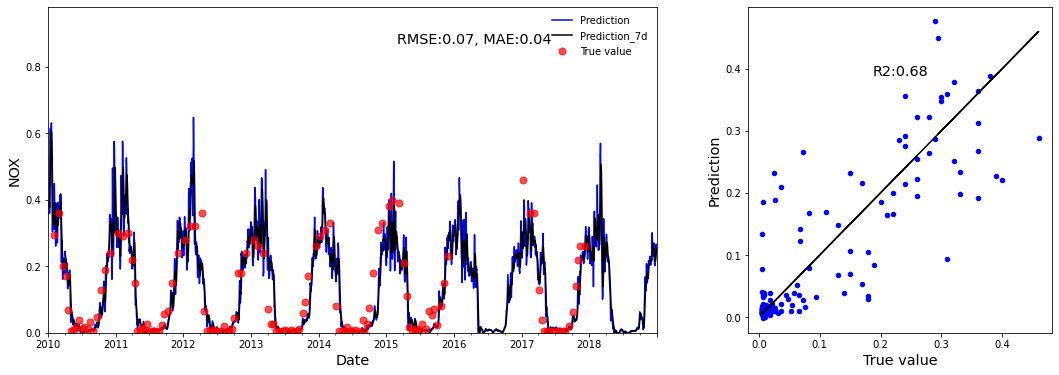

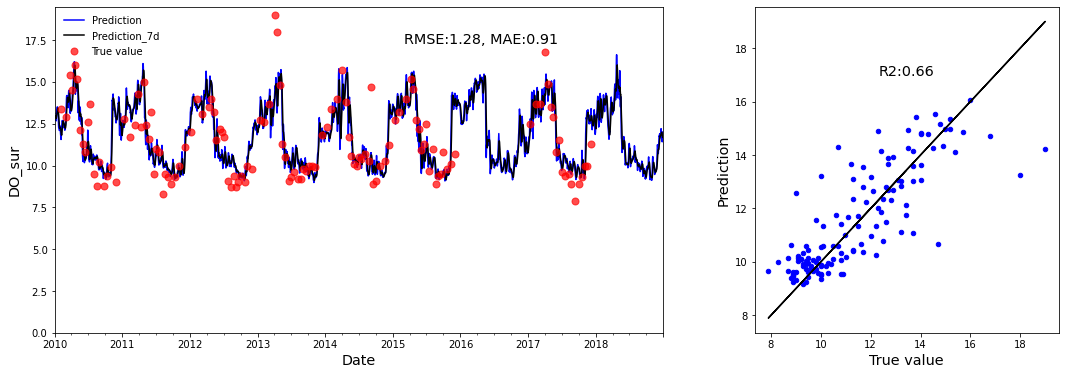

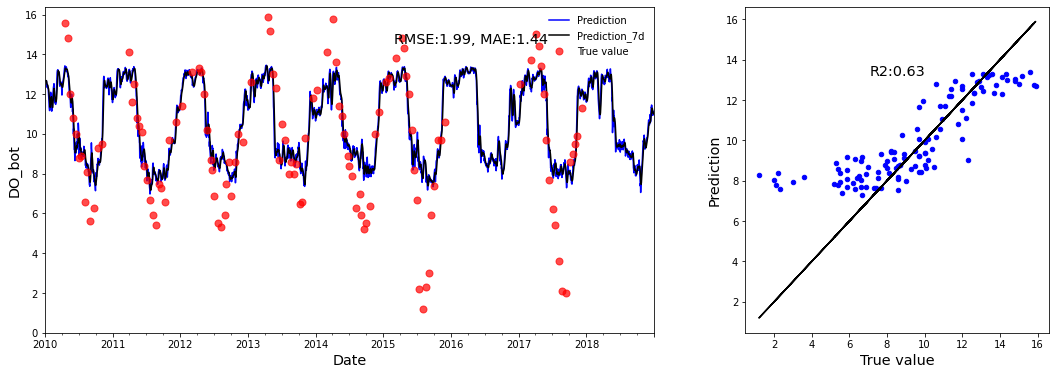

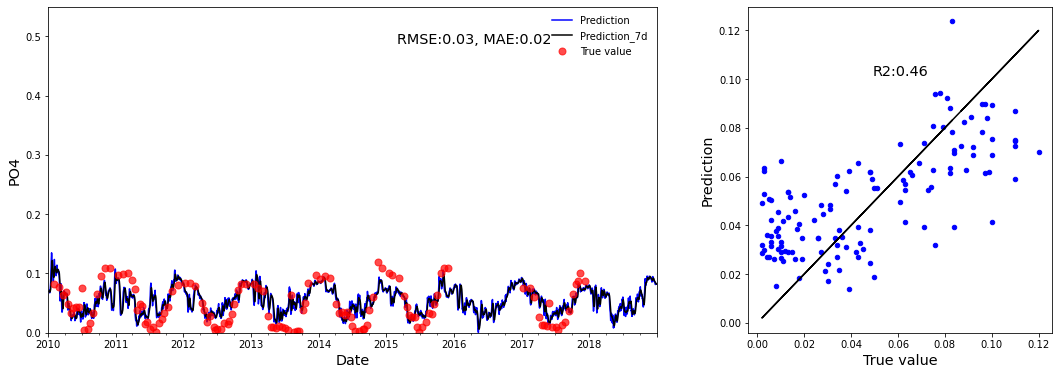

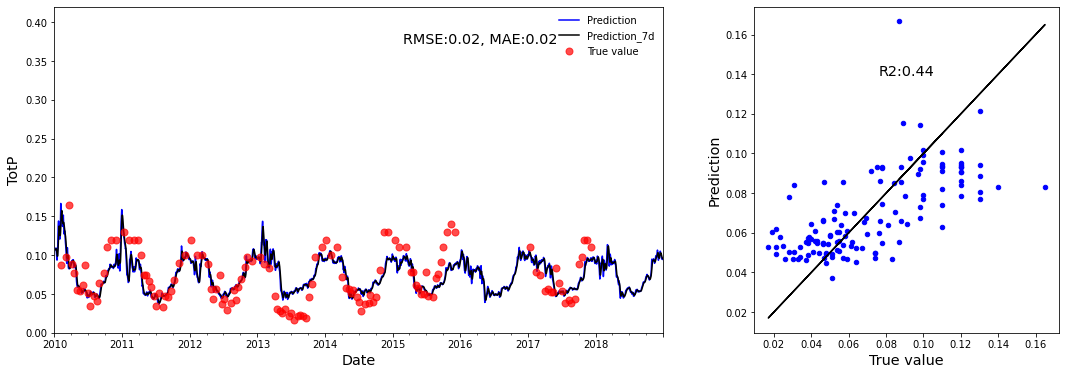

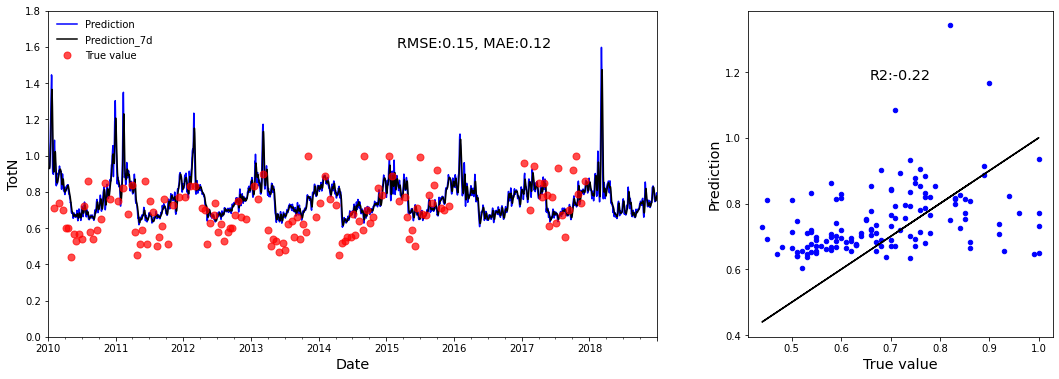

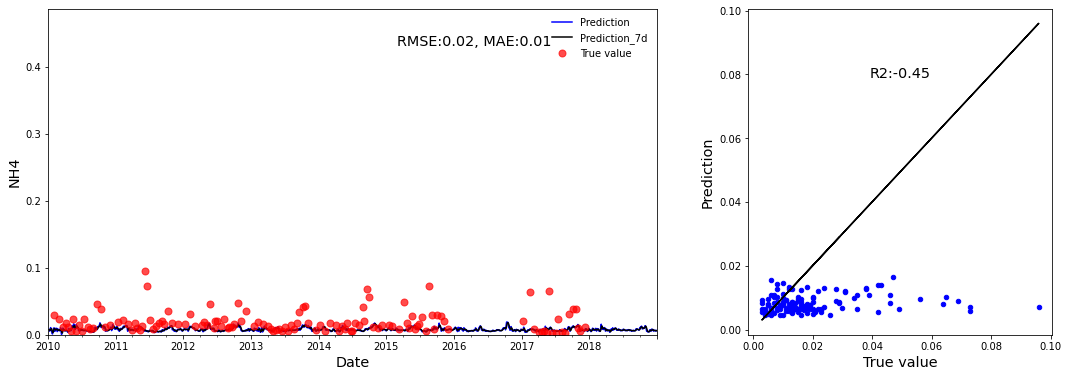

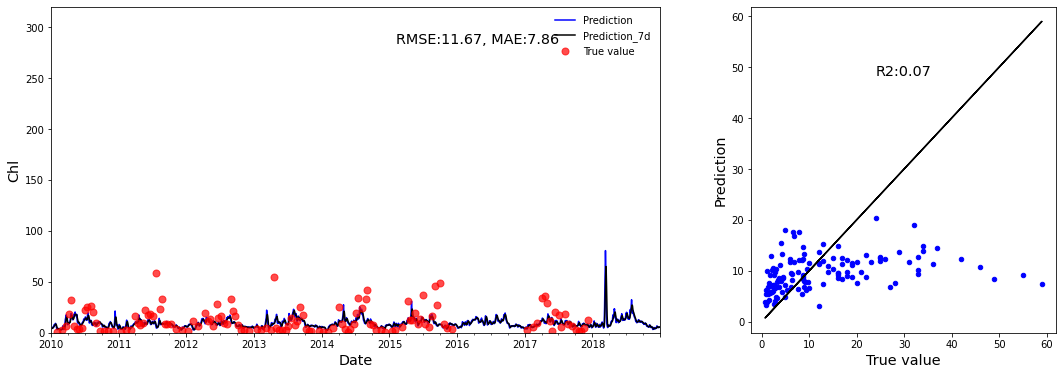

In [73]:
start_time = time.time()
os.chdir(cd+'\\Trainning data')
# Load daily physical factors
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'

Daily_df = read_daily_df(features,file) 
Daily_df = Daily_df[(Daily_df['Date']>=Dataset_range[0])&(Daily_df['Date']<=Dataset_range[1])]
features.pop(0) # Pop 'Date'
Scaler_X = MinMaxScaler()
Scaler_y = MinMaxScaler()#PowerTransformer(standardize=False)
start_time = time.time()
for j in range(n_Nut):#n_Nut
    nutrient=Nut_f[j+1]
    if j==0:
        Nut_memory = Daily_df.merge(pd.concat([Nut_df['Date'],
                                               Nut_df[nutrient]],
                                              axis = 1).dropna().drop_duplicates('Date'),
                                    how = 'left',on = 'Date')
    else: 
        Nut_memory = Nut_memory.merge(pd.concat([Nut_df['Date'],
                                               Nut_df[nutrient]],
                                              axis = 1).dropna().drop_duplicates('Date'),
                                    how = 'left',on = 'Date')

    print(nutrient)
    features.append(nutrient)
    values = load_dataset(Nut_memory,features)
    # frame as supervised learning
    reframed = reframe(values,hyperparameters,features)
    reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),
                                 columns=reframed.columns[:-1])
    target_array=pd.Series(reframed.iloc[:,-1].values.reshape(-1, 1).reshape(-1),
                 name=reframed.columns[-1])

    #target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
    #                 name=reframed.columns[-1])
    reframed_scaled=pd.concat([reframed_scaled,target_array],axis=1)
    values = reframed_scaled.values
    ylim = (0,all_df[nutrient].max())
    start_time = time.time()
    Nut_model,rmse,mae,r2,figure,pred_ts = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
    # 5-fold cross validation was used to estimate the model performance
    print('Test RMSE: %.2f' % rmse)
    print('Test MAE: %.2f' % mae)
    print('Test R2: %.2f' %r2)
    Lake_Nut_metrics[nutrient]['MAE']=mae
    Lake_Nut_metrics[nutrient]['RMSE']=rmse
    Lake_Nut_metrics[nutrient]['R2']=r2
    print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
    figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)    
    print('\n')
    Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')

In [74]:
Lake_Nut_metrics

,NOX,DO_sur,DO_bot,PO4,TotP,TotN,NH4,Chl
MAE,0.044807,0.908362,1.438478,0.020774,0.018836,0.119221,0.012384,7.863351
RMSE,0.070485,1.275407,1.992241,0.025049,0.024098,0.149789,0.01954,11.66677
R2,0.682114,0.659784,0.630555,0.462481,0.442461,-0.21534,-0.446673,0.065157


In [75]:
os.chdir(cd+'\\Scenario2\\LSTM')
Nut_memory.to_csv(lakename+'_LSTM predicted nutrient and Chl data.csv',sep='\t',index = False)
Lake_Nut_metrics.to_csv(lakename+'_LSTM_metrics.csv',index=False)

Threshold of delta_Chl:0.6
Threshold of Chl:10
Name of Chl variable: Chl


C:\Users\shuli278\AppData\Local\Temp/ipykernel_2236/2047751176.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OB_bloom['YY']=OB_bloom['Date'].apply(lambda d:d.year)


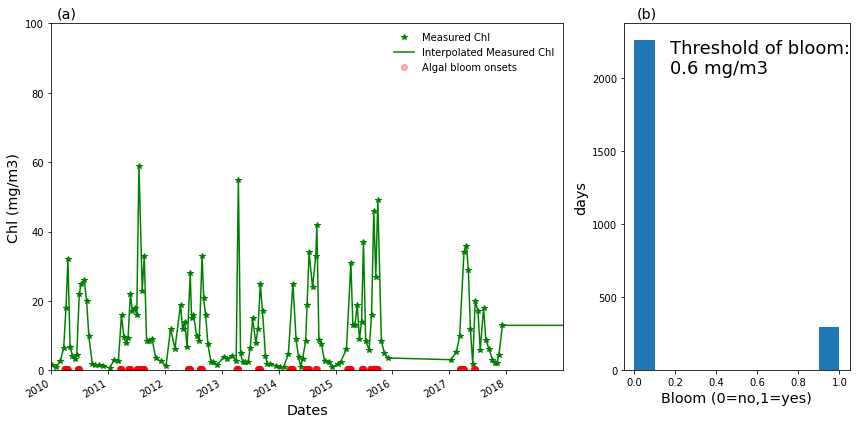

In [76]:
threshold1 = float(input('Threshold of delta_Chl:'))
threshold2 = float(input('Threshold of Chl:'))
def find_bloom(x):
    if (x['delta_Chl']>threshold1)&(x[Chl_name]>threshold2):
        return 1
    else:
        return 0

Chl_name=input('Name of Chl variable: ')
OB=all_df[['Date',Chl_name]].dropna()
OB=OB[~OB['Date'].duplicated()]
OB_int = OB.set_index('Date').reindex(pd.date_range(start = test_time[0],end = test_time[1],freq = '1D')).interpolate(method = 'linear')
OB_int = OB_int.reset_index()
OB_int.columns = ['Date','Chl']
OB_int['Date'] = OB_int['Date'].apply(lambda d:d.date())
OB_int['Date'] = pd.to_datetime(OB_int['Date'])
# Use the delta_Chl threshold to find the onset dates of algal bloom
OB_int['delta_Chl'] = np.diff(OB_int['Chl'],append=0)
OB_int['Bloom'] = OB_int.apply(lambda x: find_bloom(x), axis=1) 
OB_bloom = OB_int[['Date','Bloom']]
OB_bloom['YY']=OB_bloom['Date'].apply(lambda d:d.year)
OB_bloom=OB_bloom[OB_bloom['YY'].isin(yy)][['Date','Bloom']]

fig=plt.figure(tight_layout='pad',figsize = (12,6))

gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1])
OB_bloom['Bloom'].hist(grid=False,ax=ax2)
OB.plot(x = 'Date',y = Chl_name,style = 'g*',ax=ax1,label='Measured Chl')
OB_int.plot(x = 'Date',y = 'Chl',style = 'g-',ax=ax1,label='Interpolated Measured Chl')
ax1.plot(OB_bloom[OB_bloom['Bloom']==1]['Date'],
         OB_bloom[OB_bloom['Bloom']==1]['Bloom']*0.5,'ro',alpha=0.3,label='Algal bloom onsets')
ax1.legend(loc=0,frameon=False)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Chl (mg/m3)')
ax1.set_xlim(test_time[0],test_time[1])
ax1.set_ylim(0,100)
ax1.set_title('(a)',x=0.03)
ax2.set_xlabel('Bloom (0=no,1=yes)')
ax2.set_ylabel('days')
ax2.set_title('(b)',x=0.1)
fig.text(0.78,0.9,'Threshold of bloom: \n'+str(threshold1)+' mg/m3',fontsize=18,
         horizontalalignment='left',
         verticalalignment='top')
plt.rcParams.update({'axes.titlesize': 'x-large','axes.labelsize': 'x-large'})
fig.savefig(lakename+'_Chl observation and bloom dates.png',dpi=300)

In [77]:
OB['YY']=OB['Date'].apply(lambda d:d.year)
yy=OB[(OB['Date']>=test_time[0])&(OB['Date']<test_time[1])]['YY'].unique()
sam_int=[]
for i in range(len(yy)):
    sam_int.append(OB[OB['YY']==yy[i]]['Date'].diff().mean().days)
print('Averaged sample interval: {}'.format(round(np.nanmean(sam_int))))

Averaged sample interval: 18


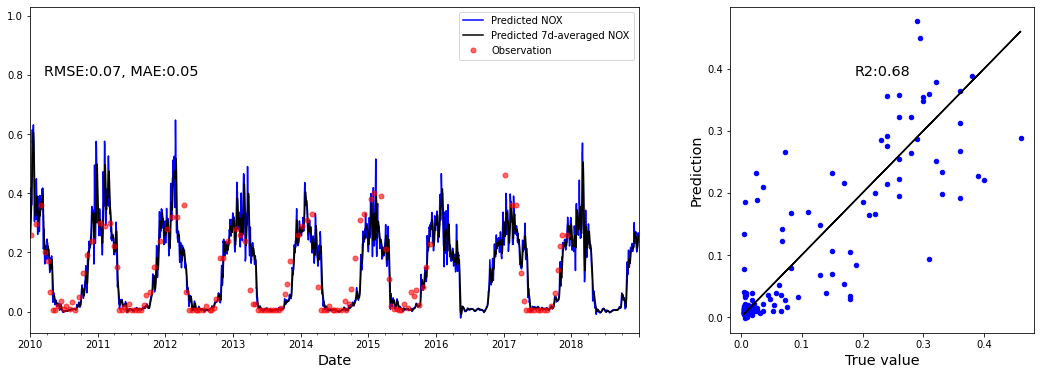

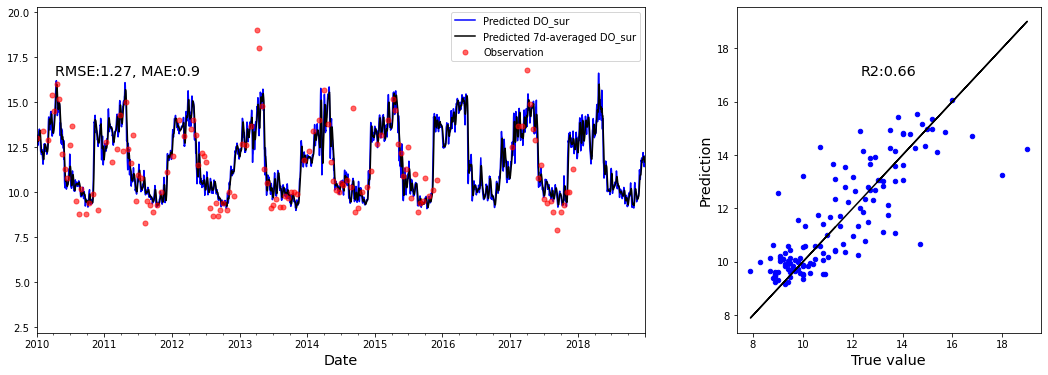

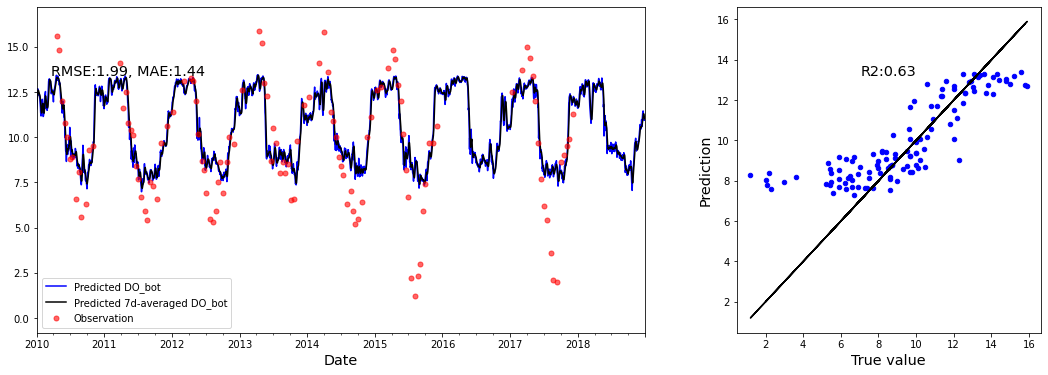

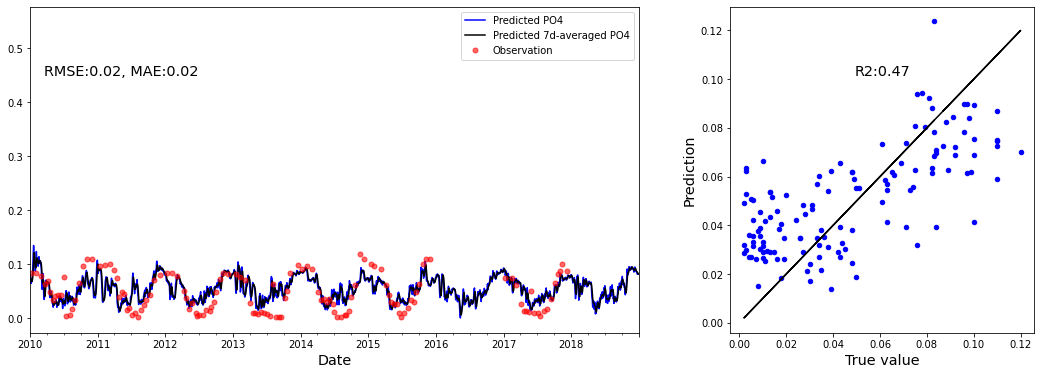

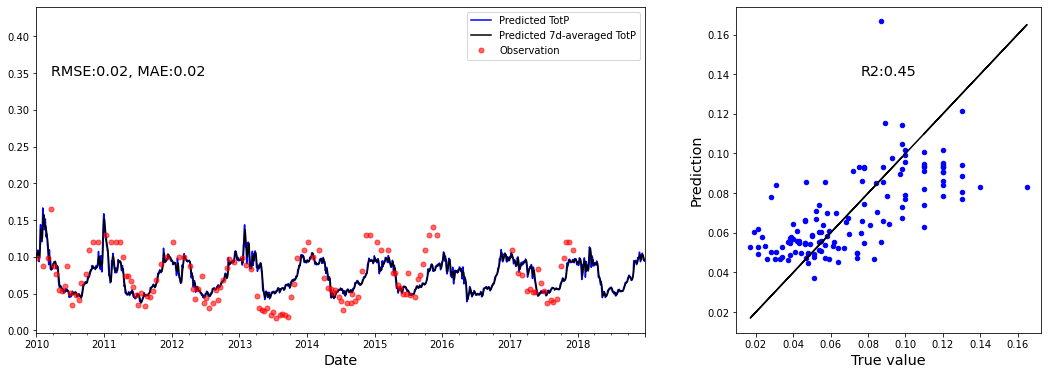

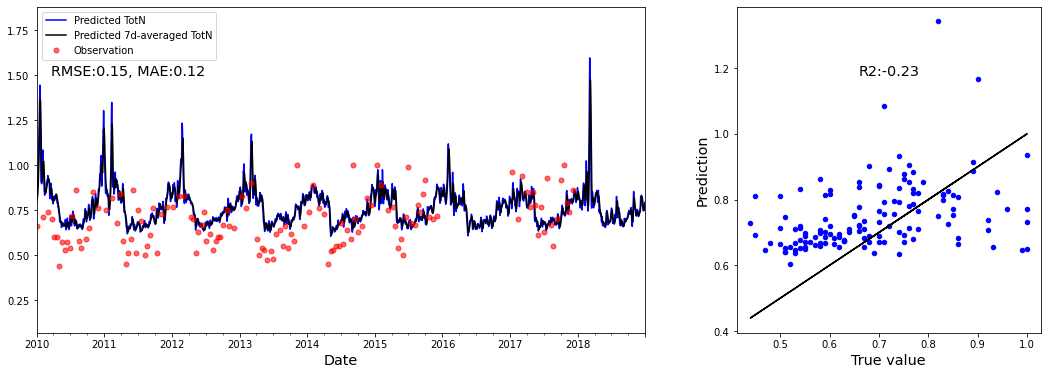

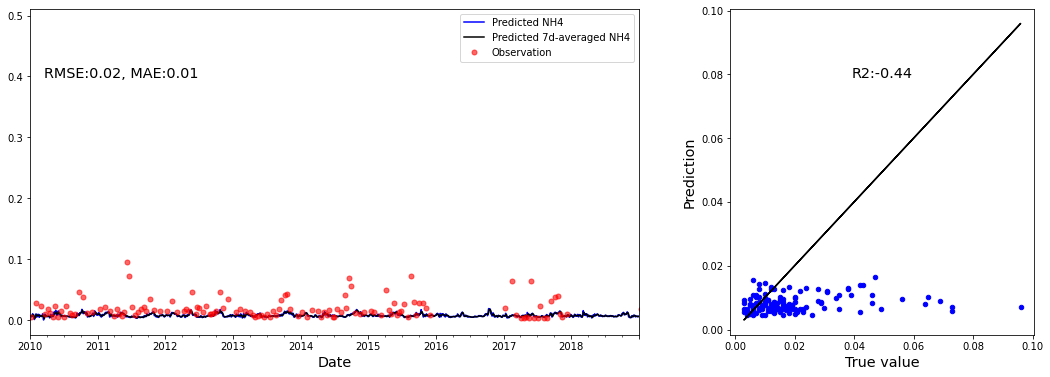

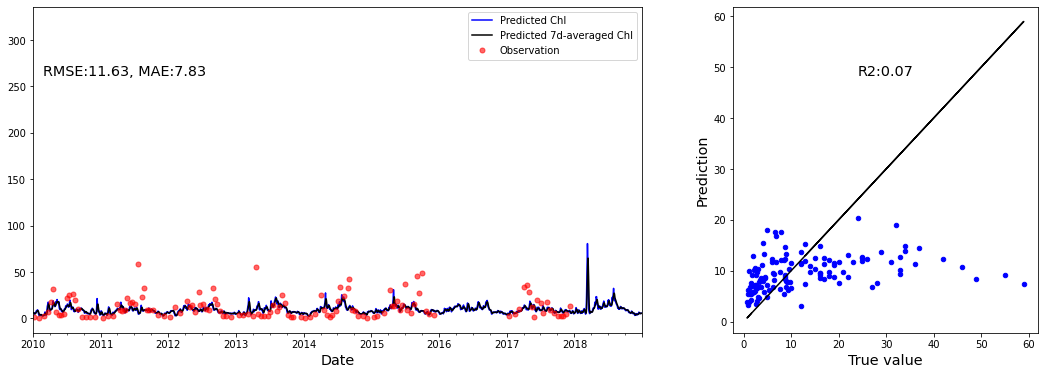

In [78]:
for k in range(1,n_Nut+1):
    nutrient_compare = Nut_memory[(Nut_memory['Date']>test_time[0])&(Nut_memory['Date']<test_time[1])][['Date',Nut_f[k]]].merge(all_df[['Date',Nut_f[k]]],how = 'inner',on = 'Date').dropna()
    nutrient_compare.columns = ['Date','Prediction','True']
    Date = pd.DataFrame(pd.date_range(start = test_time[0],
                                  end = test_time[1]),
                    columns = ['Date'])
    Lake_Nut_gap = Date.merge(Nut_memory,how = 'left',on = 'Date')
 
    RMSE = mean_squared_error(nutrient_compare['True'],nutrient_compare['Prediction'],squared=False)
    MAE = mean_absolute_error(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot time-series comparison
    f1,ax2 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    Lake_Nut_gap.plot(x = 'Date',y =Nut_f[k],c = 'b',ax = ax2[0],label = 'Predicted '+Nut_f[k])
    Lake_Nut_gap[Nut_f[k]] = Lake_Nut_gap[Nut_f[k]].rolling(7,min_periods = 1).mean()
    Lake_Nut_gap.plot(x = 'Date',y =Nut_f[k],c = 'k',ax = ax2[0],
                      label = 'Predicted 7d-averaged '+Nut_f[k])
    all_df[['Date',Nut_f[k]]].plot(x = 'Date',y =Nut_f[k],style = 'ro',ms = 5,alpha = 0.6,ax = ax2[0],
                               label = 'Observation')
    ax2[0].text(0.15, 0.8, 'RMSE:{}, MAE:{}'.format(round(RMSE,2),round(MAE,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[0].transAxes,fontsize='x-large')

    ax2[0].set_xlim((test_time[0],test_time[1]))
    #ax2[0].set_ylim(Lake_Nut[Nut[k]].min(),Lake_Nut[Nut[k]].max())

    R2 = r2_score(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot scatter plot
    ax2[1].scatter(nutrient_compare['True'],nutrient_compare['Prediction'],s = 20,c = 'blue')
    ax2[1].plot(nutrient_compare['True'],nutrient_compare['True'],lw  =1.5,color = 'black')    
    ax2[1].set_xlabel('True value')
    ax2[1].set_ylabel('Prediction')
    ax2[1].text(0.5, 0.8, 'R2:{}'.format(round(R2,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[1].transAxes,fontsize='x-large')
    f1.savefig(lakename+'_LSTM_'+Nut_f[k]+'.png',dpi = 500)

In [31]:
os.getcwd()

'C:\\Users\\shuli278\\Documents\\D\\PDF_Uppsala\\7-Python code of ML algorithm\\GitHub\\Algal-bloom-prediction-machine-learning\\Algal-bloom-prediction-machine-learning\\Scenario2\\LSTM'

In [79]:
sample_interval=int(input('Sample interval: ')) # 7
rolling_interval=int(input('Rolling interval: '))
rolling_threshold=float(input('Rolling bloom threshold: '))

ML_Chl = Nut_memory[['Date',Chl_name]]
ML_Chl[Chl_name]=ML_Chl[Chl_name].rolling(sample_interval,min_periods = 1).mean()
ts=pd.DataFrame(pd.date_range(start=ML_Chl['Date'].iloc[0],
                              end=ML_Chl['Date'].iloc[-1],
                              freq='D'),
                columns=['Date'])
ML_Chl=ts.merge(ML_Chl,on='Date',how='left')
ML_Chl['delta_Chl'] = np.diff(ML_Chl[Chl_name],append = 0)

ML_Chl['Bloom'] = ML_Chl.apply(lambda x: find_bloom(x),axis=1)
ML_bloom = ML_Chl[['Date','Bloom']]
ML_bloom['rolling_bloom']=ML_bloom['Bloom'].rolling(rolling_interval,
                                                      center=False,
                                                      closed='both').mean().apply(lambda x: 1 if x>=rolling_threshold else 0)
# Find the model hits the events or not
Event_detection = OB_bloom.merge(ML_bloom[['Date','rolling_bloom']],how = 'inner',on = 'Date')
Event_detection.columns = ['Date','OB','ML']

tn, fp, fn, tp=confusion_matrix(Event_detection['OB'],Event_detection['ML']).ravel() 
(tn, fp, fn, tp)
TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
accuracy=(tn+tp)/(tn+tp+fn+fp)
precision=tp/(tp+fp)
prevalence=(fn+tp)/(tn+tp+fn+fp)
f1=tp/(tp+0.5*(fp+fn))
pe=((tp+fp)/(tn+tp+fn+fp)*(fn+tn)/(tn+tp+fn+fp))+((tp+fn)/(tn+tp+fn+fp)*(fp+tn)/(tn+tp+fn+fp))
kappa=(accuracy-pe)/(1-pe)

print('LSTM model_Scenario 3')
print('TPR: {},\nFPR: {}, \naccuracy: {}, \nprecision: {}, \nprevalence: {},\nf1: {}, \nkappa:{}.'.format(round(TPR,2),
                                                                                                          round(FPR,2),
                                                                                                          round(accuracy,2),
                                                                                                          round(precision,2),
                                                                                                          round(prevalence,2),
                                                                                                          round(f1,2),
                                                                                                          round(kappa,2)))

Metrics=pd.DataFrame({'TPR':[TPR],'FPR':[FPR],'Accuracy': [accuracy],'Precision':[precision],
             'prevalence':[prevalence],'F1':[f1],'Kappa':[kappa]},index=['ML'])

Sample interval: 10
Rolling interval: 3
Rolling bloom threshold: 0.01
LSTM model_Scenario 3
TPR: 0.03,
FPR: 0.05, 
accuracy: 0.85, 
precision: 0.08, 
prevalence: 0.12,
f1: 0.04, 
kappa:0.82.


C:\Users\shuli278\AppData\Local\Temp/ipykernel_2236/3316177399.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_Chl[Chl_name]=ML_Chl[Chl_name].rolling(sample_interval,min_periods = 1).mean()
C:\Users\shuli278\AppData\Local\Temp/ipykernel_2236/3316177399.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ML_bloom['rolling_bloom']=ML_bloom['Bloom'].rolling(rolling_interval,


Text(0, 0.5, '(%)')

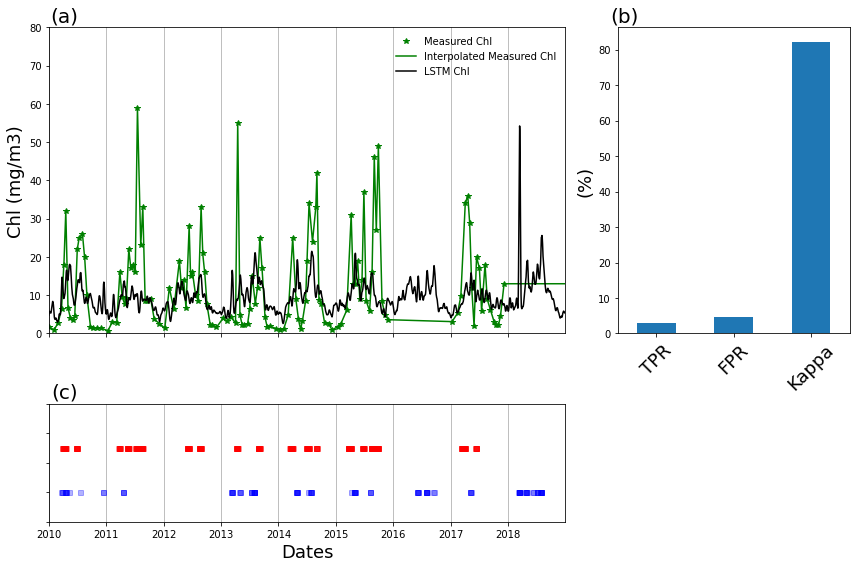

In [81]:
fig=plt.figure(tight_layout='True',figsize = (12,8))
gs = fig.add_gridspec(3, 3)
ax1 = fig.add_subplot(gs[0:2, :-1])
ax2 = fig.add_subplot(gs[2, :-1])
ax3 = fig.add_subplot(gs[0:2, -1])

OB.plot(x = 'Date',y = Chl_name,style = 'g*',ax=ax1,label='Measured Chl')
OB_int.plot(x = 'Date',y = 'Chl',style = 'g-',ax=ax1,label='Interpolated Measured Chl')
ML_Chl.plot(x = 'Date',y = Chl_name,style = 'k',ax=ax1,label='LSTM Chl')
ax1.set_ylim(0,80)
ax2.plot(OB_bloom[OB_bloom['Bloom']==1]['Date'],
         OB_bloom[OB_bloom['Bloom']==1]['Bloom']*0.5,'rs',alpha=0.3,markersize=5,
         label='Observed algal bloom onsets')
ax2.plot(ML_bloom[ML_bloom['Bloom']==1]['Date'],
         ML_bloom[ML_bloom['Bloom']==1]['Bloom']*0.5-0.3,'bs',alpha=0.3,markersize=5,
         label='Predicted algal bloom onsets')
ax1.legend(loc=0,frameon=False)
ax1.set_xlabel(' ')
ax1.set_xticklabels([])
ax1.set_ylabel('Chl (mg/m3)',fontsize=18)
ax1.set_xlim(test_time[0],test_time[1])
ax1.set_title('(a)',x=0.03,fontsize=20)
ax2.set_xlim(test_time[0],test_time[1])
ax2.set_ylabel(' ')
ax2.set_ylim(0,0.8)
ax2.set_yticklabels([])
ax2.set_xlabel('Dates',fontsize=18)
ax2.set_title('(c)',x=0.03,fontsize=20)
ax1.grid(axis='x')
ax2.grid(axis='x')

(Metrics[['TPR','FPR','Kappa']]*100).T.plot(kind='bar',ax=ax3)
ax3.legend('',frameon=False)
ax3.set_xticklabels(['TPR','FPR','Kappa'],rotation=45,fontsize=18)
ax3.set_title('(b)',x=0.03,fontsize=20)
ax3.set_ylabel('(%)',fontsize=18)

In [35]:
fig.savefig(lakename+'_LSTM_Chl_bloom time.png',dpi = 500)